**Livrable** : Un ou des notebooks (ou des fichiers .py) contenant les fonctions permettant le prétraitement et la feature extraction des données textes et images ainsi que les résultats de l’étude de faisabilité (graphiques, mesure de similarité) 

In [6]:
%%capture
!python -m spacy download en_core_web_md
!python -m spacy download en_core_web_trf

In [7]:
import psutil

In [8]:
def get_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Convert bytes to MB

print(f"Current memory usage: {get_memory_usage():.2f} MB")


Current memory usage: 677.21 MB


In [9]:
# Importation des librairies standards
import os
import time
import logging
import pickle

# Importation des librairies pour la manipulation des données
import numpy as np
import pandas as pd

# Importation des librairies de visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Importation des librairies pour le traitement du langage naturel (NLP)
import nltk
import gensim
import spacy
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Importation des librairies pour l'apprentissage automatique et le deep learning
from sklearn import cluster, metrics, manifold, decomposition
from umap import UMAP
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Importation d'OpenCV pour la manipulation d'images
import cv2

# Désactiver les messages WARNING, INFO et DEBUG
logging.disable(logging.WARNING)


# Lecture du jeu de données flipkart

In [10]:
# Read the content of the flipkart.csv file
flipkart = pd.read_csv('pj1_flipkart.csv', encoding='utf-8', encoding_errors='replace', parse_dates=['crawl_timestamp'])

In [11]:
# Print the information of the flipkart DataFrame
print(flipkart.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   uniq_id                  1050 non-null   object             
 1   crawl_timestamp          1050 non-null   datetime64[ns, UTC]
 2   product_url              1050 non-null   object             
 3   product_name             1050 non-null   object             
 4   product_category_tree    1050 non-null   object             
 5   pid                      1050 non-null   object             
 6   retail_price             1049 non-null   float64            
 7   discounted_price         1049 non-null   float64            
 8   image                    1050 non-null   object             
 9   is_FK_Advantage_product  1050 non-null   bool               
 10  description              1050 non-null   object             
 11  product_rating           1050 

# Commentaires sur le fichier flipkart après visualisation sur le data wrangler

| Champs                    | Description                                                                                  | Utile |
|---------------------------|----------------------------------------------------------------------------------------------|-------|
| uniq_id                   | Nom des fichiers images dans le répertoire image                                             | O     |
| crawl_timestamp           | Timestamp du crawler qui a récupéré les images                                               | N     |
| product_url               | Lien URL contenant le product_name & le PID                          | N     |
| product_name              | Nom du produit extrait de l'URL                                                             | O     |
| product_category_tree     | Fil d'ariane à extraire de la catégorie de produit categorical                               | O     |
| pid                       | Product ou Page ID                                                                                   | N     |
| retail_price              | Prix                                                                                         | O     |
| discounted_price          | Prix réduit                                                                                  | O     |
| image                     | La même chose que uniq_id mais avec le format à la fin                                       | O     |
| is_FK_Advantage_product   | Série booléenne de ?                                                                         | N     |
| description               | Description string du produit                                                                | O     |
| product_rating            | Note moyenne, attention les valeurs nulles sont remplacées par 'No rating available'         | O     |
| overall_rating            | Semble identique                                                                             | N     |
| brand                     | La marque, contient beaucoup de valeurs manquantes, peut être récupéré du product name       | N     |
| product_specifications    | Sous forme de K-V pair sur les key feature du produit                                        | O     |


# Vérification sur les champs

En plus du fichier flipkart, nous avons un répertoire contenant les images des produits. <br>
**Nous allons vérifier si les images dans le répertoire correspondent aux images dans le fichier flipkart** pour pouvoir ensuite rapprocher le dataset avec les images.

In [12]:
# Count the number of files in the current directory
print("Nombre de fichiers dans le répertoire Images: ", len(os.listdir("./Images")))

# Check if the number of lines in the flipkart.csv file is equal to the number of files in the Images directory
assert (
    len(os.listdir("./Images")) == len(flipkart)
), "Le nombre de lignes ne corresponds pas au nombre de fichiers dans le repertoire Images"

# Check if the uniq_id column has the same names than the files in the Images directory
files_without_jpg = [file.strip(".jpg") for file in os.listdir("./Images")]
assert (
    flipkart["uniq_id"].isin(files_without_jpg).all()
), "Les fichiers dans le repertoire Images ne correspondent pas aux fichiers dans le fichier flipkart.csv"
print("La colonne uniq_id contient les mêmes noms que les fichiers dans le répertoire Images")


Nombre de fichiers dans le répertoire Images:  1050
La colonne uniq_id contient les mêmes noms que les fichiers dans le répertoire Images


In [13]:
# Check if the image column is equal to the uniq_id column with the .jpg extension
assert flipkart["uniq_id"].equals(
    flipkart["image"].str.strip(".jpg")
), "les colonnes image sans l'extension .jpg et uniq_id ne correspondent pas"
print("La colonne image est égale à la colonne uniq_id sans l'extension .jpg")


La colonne image est égale à la colonne uniq_id sans l'extension .jpg


In [14]:
# Check if the image column contains different image formats
print("Les formats d'images sont:")
flipkart['image'].str.rsplit('.', expand=True)[1].value_counts()

Les formats d'images sont:


1
jpg    1050
Name: count, dtype: int64

In [15]:
# Check if the product_rating column is equal to the overall_rating column
assert flipkart["product_rating"].equals(
    flipkart["overall_rating"]
), "les colonnes product_rating et overall_rating ne correspondent pas"
print("La colonne product_rating est égale à la colonne overall_rating")


La colonne product_rating est égale à la colonne overall_rating


# Extraction des catégories de produits

**Nous allons extraire les catégories de produits pour pouvoir les utiliser dans la classification des produits.**<br>
Chaque catégorie est séparée par un '>>' et nous allons les séparer et les stocker dans une colonne 'category_1', 'category_2', 'category_3' etc...<br>
La colonne 'category_1' contient la catégorie principale, 'category_2' la sous-catégorie et 'category_3' la sous-sous-catégorie, etc...

In [16]:
# Extract the categories from the product_category_tree column into separate columns
categories = (
    flipkart["product_category_tree"].str.strip('["|"]')
    .str.split(">>", expand=True)
    .rename(columns={i: f'category_{i}' for i in range(0, 7)})
    )

# Concatenate the flipkart and categories dataframes and drop the product_category_tree column
flipkart_with_cat = (
    pd.concat([flipkart, categories], axis=1)
    .drop("product_category_tree", axis=1)
)

# Sélection des colonnes utiles

**Pour la suite de l'analyse, on va sélectionner les colonnes utiles pour la classification des produits.**<br>
On travaillera sur les colonnes 'product_name', 'description' et 'product_specifications' pour les données textes et sur les colonnes 'image' pour les données images.<br>
Concernant la colonne 'product_specifications', il est encore difficile de savoir si l'on va l'utiliser pour la classification des produits. Nous allons donc la conserver pour le moment.

In [17]:
fields = [
    "uniq_id",
    "image",
    "product_name",
    "category_0",
    "category_1",
    "category_2",
    "category_3",
    "category_4",
    "category_5",
    "category_6",
    "retail_price",
    "discounted_price",
    "description",
    "product_rating",
    "product_specifications"
]

J'appellerai le nouveau dataframe `flipkart_filtered` qui contiendra les colonnes utiles pour la classification des produits.	

In [18]:
# Create a new DataFrame with the selected fields
flipkart_filtered = flipkart_with_cat[fields].copy()

# Remplacement des ratings nuls

In [19]:
# Replace the text "No rating available" by 0 in the product_rating column and convert it to float
flipkart_filtered = flipkart_filtered.assign(**{'product_rating': lambda x: x['product_rating'].replace('No rating available', np.nan).astype(float)})

# Identification des erreurs d'encodage dans les colonnes textes

J'ai identifié un problème d'encodage dans les colonnes textuelles avec le caractère �.<br>
Regardons les colonnes textuelles pour vérifier la présence de ce caractère.

In [20]:
# Define the problematic pattern
pattern = "�"

# Check if the flipkart_filtered DataFrame contains the character �
flipkart_filtered.select_dtypes(include='object').apply(lambda x: x.str.count(pattern).sum())

uniq_id                    0.0
image                      0.0
product_name               3.0
category_0                 0.0
category_1                 0.0
category_2                 0.0
category_3                 0.0
category_4                 1.0
category_5                 0.0
category_6                 0.0
description               11.0
product_specifications     4.0
dtype: float64

In [21]:
# Create a new list
words = []
non_words = []

# Create a pattern to match words containing the character � with a pattern like "___" which doesn't exist in the text
word_pattern = r"\b\w*___\w*\b"
nonword_pattern = r"\b\W*___\W*\b"

# Add each word with word_pattern to the words list and each word with nonword_pattern to the non_words list
for column in flipkart_filtered.select_dtypes(include='object').replace('�', '___'):
    words.append((column, flipkart_filtered[column].dropna().str.replace('�', '___').str.findall(word_pattern).sum()))
    non_words.append((column, flipkart_filtered[column].dropna().str.replace('�', '___').str.findall(nonword_pattern).sum()))

# Print the words and non_words lists
print(words)
print(non_words)

[('uniq_id', []), ('image', []), ('product_name', ['Repouss______', '___']), ('category_0', []), ('category_1', []), ('category_2', []), ('category_3', []), ('category_4', ['___']), ('category_5', []), ('category_6', []), ('description', ['Repouss______', 'Repouss______', '___To', '___', '___To', '___', '___', 'd___cor', 'd___cor']), ('product_specifications', ['Repouss______', 'Repouss______'])]
[('uniq_id', []), ('image', []), ('product_name', [' ___ ']), ('category_0', []), ('category_1', []), ('category_2', []), ('category_3', []), ('category_4', [' ___ ']), ('category_5', []), ('category_6', []), ('description', ['.___\r\n', '.___', ' ___ ']), ('product_specifications', [])]


Après inspection des passages concernée, je peux remplacer les passages spécifiques avec "Repouss��" et "d�cor" par "Repousse" et "decor" respectivement.<br>
Pour le reste, je vais supprimer les occurences de ce caractère.

In [22]:
# Define the pattern to match
pattern_1 = "Repouss��"
pattern_2 = "d�cor"

# Replace the pattern_1 by "Repoussé" and the pattern_2 by "décor" in the product_specifications column
for column in flipkart_filtered.select_dtypes(include='object'):
    flipkart_filtered[column] = flipkart_filtered[column].str.replace(pattern_1, "Repoussé").str.replace(pattern_2, "décor").str.replace(pattern, '')

# Check if the flipkart_filtered DataFrame contains the character �
assert flipkart_filtered.select_dtypes(include='object').apply(lambda x: x.str.count(pattern).sum()).sum() == 0.0, "Il reste encore des caractères � dans le DataFrame"

# EDA sur les colonnes


In [23]:
flipkart_filtered

,uniq_id,image,product_name,category_0,category_1,category_2,category_3,category_4,category_5,category_6,retail_price,discounted_price,description,product_rating,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet...,None,None,None,1899.0,899.0,Key Features of Elegance Polyester Multicolor ...,NaN,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",None,None,600.0,449.0,Specifications of Sathiyas Cotton Bath Towel (...,NaN,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Eurospa Cotton Terry Face Towel Set,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE...,None,None,NaN,NaN,Key Features of Eurospa Cotton Terry Face Towe...,NaN,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King siz...,None,None,2699.0,1299.0,Key Features of SANTOSH ROYAL FASHION Cotton P...,NaN,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double ...,None,None,2599.0,698.0,Key Features of Jaipur Print Cotton Floral Kin...,NaN,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker,Baby Care,Baby & Kids Gifts,Stickers,Oren Empower Stickers,None,None,None,1399.0,999.0,Oren Empower Extra Large Self Adhesive Sticker...,NaN,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,None,None,None,4930.0,1896.0,Wallmantra Large Vinyl Sticker Sticker (Pack o...,NaN,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,5912e037d12774bb73a2048f35a00009.jpg,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Baby Care,Baby & Kids Gifts,Stickers,Uberlyfe Stickers,None,None,None,4500.0,1449.0,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,NaN,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Wallmantra Medium Vinyl Sticker Sticker,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,None,None,None,3465.0,1333.0,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,NaN,"{""product_specification""=>[{""key""=>""Number of ..."


In [24]:
for i in range(1, 7):
    print("Number of categories in category_{}:".format(i))
    print(flipkart_filtered[f'category_{i}'].nunique())

Number of categories in category_1:
63
Number of categories in category_2:
246
Number of categories in category_3:
350
Number of categories in category_4:
297
Number of categories in category_5:
117
Number of categories in category_6:
57


Dans le cadre de l'analyse de texte, trois options se proposent à nous pour évaluer la segmentation non supervisée des produits à la liste déjà existante de catégories de produits.
- **Option 1** : Utiliser les colonnes 'product_name', 'description', variable que nous appellerons `text`.
- **Option 2** : Utiliser les colonnes uniquement 'product_name'.
- **Option 3** : Utiliser les colonnes uniquement 'description'.

In [25]:
# Concatenante the product_name and description columns
flipkart_filtered["text"] = flipkart_filtered["product_name"] + " " + flipkart_filtered["description"]

Nous allons étudier parmi les deux colonnes plusieurs statistiques descriptives pour mieux comprendre leur composition et leur distribution.<br>
Pour faciliter la tâche, je vais utiliser Spacy pour tokeniser les colonnes 'product_name', 'description' et `text` puis réaliser l'étude des tokens.<br>
Concernant le modèle, je vais utiliser le modèle 'en_core_web_trf' pour sa performance sur la lemmatisation.

In [26]:
# Load the en_core_web_trf model
trf = spacy.load("en_core_web_trf")

# Display the pipeline components into the trf
print('Liste des composantes du pipeline:')
print(trf.pipe_names)

Liste des composantes du pipeline:
['transformer', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


Seul le NER n'a aucun impact sur la qualité de la lemmatisation donc nous le désactivons :

In [27]:
# Deactivate the NER component
print('Composante désactivée: ', trf.disable_pipes("ner"))

Composante désactivée:  ['ner']


In [28]:
# Define a list with our 3 columns
options = ["product_name", "description", "text"]

In [29]:
for option in options:
    # Create a doc object for each column in the options list
    flipkart_filtered[option + "_nb_tokens"] = [len(doc) for doc in flipkart_filtered[option].str.split()]

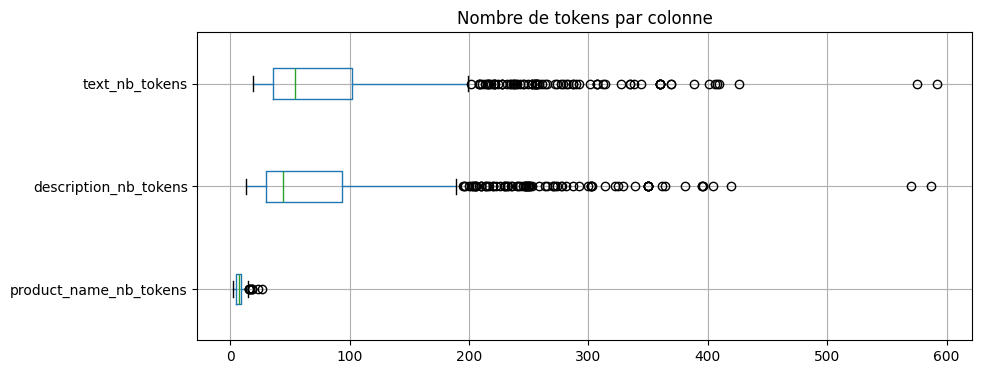

In [30]:
flipkart_filtered.boxplot(column=["product_name_nb_tokens", "description_nb_tokens", "text_nb_tokens"], vert=False, figsize=(10, 4)).set(title="Nombre de tokens par colonne")
plt.show()

In [31]:
flipkart_filtered[['product_name_nb_tokens', 'description_nb_tokens', 'text_nb_tokens']].describe()

,product_name_nb_tokens,description_nb_tokens,text_nb_tokens
count,1050.000000,1050.000000,1050.000000
mean,7.266667,76.201905,83.468571
std,2.890656,74.850937,75.194260
min,2.000000,13.000000,19.000000
25%,5.000000,30.000000,36.000000
50%,7.000000,44.000000,54.000000
75%,9.000000,94.000000,102.000000
max,27.000000,587.000000,592.000000


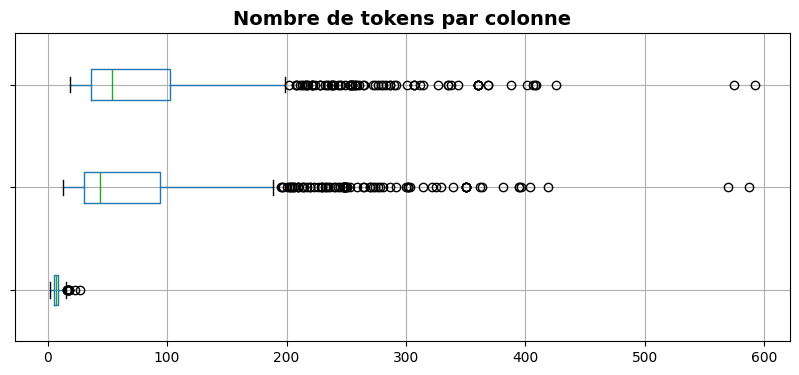

In [32]:
# Draw a horizontal boxplot for the product_name_nb_tokens, description_nb_tokens and text_nb_tokens columns of the flipkart_filtered DataFrame
ax = flipkart_filtered.boxplot(column=["product_name_nb_tokens", "description_nb_tokens", "text_nb_tokens"], vert=False, figsize=(10, 4))
# Set the y ticks with bold font
ax.set_yticklabels([], fontweight='bold')
ax.set_title("Nombre de tokens par colonne", fontweight='bold', fontsize=14)
plt.show()

# METHODOLOGIE DU CLUSTERING ET DES EMBEDDINGS

En fonction du type d'embeddings que nous allons utiliser, nous allons choisir une méthode de clustering adaptée.<br>
Passons en revue les différents types d'embeddings :
* **CountVectorizer** : Génère un BOW (fréquence de chaque mot présent dans le corpus au sein de chaque document). En fonction du nombre de dimensions obtenues, il sera peut-être nécessaire de réduire la dimensionnalité avant d'utiliser une méthode de clustering.
* **TfidfVectorizer** : Génère un BOW pondéré par l'inverse de la fréquence du mot dans le corpus. En fonction du nombre de dimensions obtenues, il sera peut-être nécessaire de réduire la dimensionnalité avant d'utiliser une méthode de clustering.

La démarche est de générer différents BOW et de tester l'ARI.<br>
Une première étape importante sur les BOW est de réduire la dimensionnalité pour éviter le fléau de la dimensionnalité.<br>
Afin de gagner du temps sur les calculs, nous allons créer nos corpus de texte dans un dictionnaire `corpus`:

In [33]:
def spacy_preprocessor(doc):
    return " ".join([token.lemma_ for token in trf(doc) if not token.is_stop and not token.like_num and token.is_alpha])

Nous allons créer deux corpus de documents :
* `corpus`: contient tous les documents textes sans preprocessing quelconque.
* `corpus_preprocessed`: contient tous les documents textes après preprocessing.

In [34]:
# Création des deux dictionnaires
corpus = dict()
corpus_preprocessed = dict()

# check if the corpus and corpus_preprocessed dictionaries has a pkl file in the current directory
if os.path.exists("corpus.pkl") and os.path.exists("corpus_preprocessed.pkl"):
    # Load the corpus and corpus_preprocessed dictionaries from the pkl files
    with open("corpus.pkl", "rb") as file:
        corpus = pickle.load(file)
    with open("corpus_preprocessed.pkl", "rb") as file:
        corpus_preprocessed = pickle.load(file)

# If not, create the dictionaries
else:
    # Itére sur options
    for option in tqdm(options):
        # Assigne la variable texte à la colonne option
        text = flipkart_filtered[option].dropna().str.lower()
        # Création d'une liste de textes
        corpus[option] = text.tolist()
        # Crée une liste de tokens pour chaque texte dans text
        corpus_preprocessed[option] = [" ".join(token.lemma_ for token in doc if not token.is_stop and not token.like_num and token.is_alpha) for doc in trf.pipe(text)]
    # Sauvegarde les dictionnaires dans des fichiers pkl
    with open("corpus.pkl", "wb") as file:
        pickle.dump(corpus, file)
    with open("corpus_preprocessed.pkl", "wb") as file:
        pickle.dump(corpus_preprocessed, file)


On peut regarder à présent si nous avons des pattern à haute fréquence dans les documents textes et de vérifier s'il s'agit de bruit:

In [35]:
# Assign the CountVectorizer instance to the vectorizer variable
cv = CountVectorizer(strip_accents='unicode')
cv_preprocessed = CountVectorizer(strip_accents='unicode')

In [36]:
# Assigne un dictionnaire qui contiendra les embeddings des textes
cv_embeddings = dict()
cv_preprocessed_embeddings = dict()

# Itère sur options
for option in tqdm(options):
        current_text = corpus[option]
        current_text_preprocessed = corpus_preprocessed[option]

        # Fit the vectorizer on the text column
        cv.fit(current_text)
        cv_preprocessed.fit(current_text_preprocessed)

        # Récupération du nom des features
        features = cv.get_feature_names_out()
        features_preprocessed = cv_preprocessed.get_feature_names_out()

        # Transform the text column
        X = cv.transform(current_text)
        X_preprocessed = cv_preprocessed.transform(current_text_preprocessed)

        # Création d'un BOW sous forme de dataframe qu'on affecte dans le dictionnaire
        cv_embeddings[option] = pd.DataFrame(X.toarray(), columns=features)
        cv_preprocessed_embeddings[option] = pd.DataFrame(X_preprocessed.toarray(), columns=features_preprocessed)

100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


On veut regarder les mots les plus fréquents avec le count vectorizer sur la séquence préprocessée et comparer avec la séquence brut(sans ponctuation).

In [37]:
# On veut récupérer la fréquence relative de chaque mot dans chaque colonne
for option in options:
    cv_embeddings[f'{option}_freq'] = cv_embeddings[option].div(cv_embeddings[option].sum(axis=1), axis=0)
    cv_preprocessed_embeddings[f'{option}_freq'] = cv_preprocessed_embeddings[option].div(cv_preprocessed_embeddings[option].sum(axis=1), axis=0)

Regardons le top 10 des mots les fréquents sur le texte non nettoyé :

In [38]:
for option in options:
    print(f"Top 10 words in {option} column:")
    print(cv_embeddings[f'{option}_freq'].sum().sort_values(ascending=False).head(10))
    print()

Top 10 words in product_name column:
for          21.679211
watch        21.508020
set          19.376070
analog       18.288997
cm           15.751661
showpiece    14.928320
baby         14.774614
combo        13.674623
ceramic      13.387908
mug          13.137908
dtype: float64

Top 10 words in description column:
only        26.911401
for         24.045444
rs          21.939549
at          20.255739
on          19.841916
free        18.607854
products    18.563147
buy         18.219676
delivery    18.197298
shipping    18.189398
dtype: float64

Top 10 words in text column:
for         23.607774
only        22.380297
rs          18.403008
at          16.752656
on          16.641672
of          16.598850
free        15.456056
products    15.382443
buy         15.098986
delivery    15.025199
dtype: float64



Regardons enfin la fréquence avec le texte prétraitée :

In [39]:
for option in options:
    print(f"Top 10 words in {option} column:")
    print(cv_preprocessed_embeddings[f'{option}_freq'].sum().sort_values(ascending=False).head(10))
    print()

Top 10 words in product_name column:
watch        31.661508
analog       26.623016
set          21.573773
cm           19.642940
showpiece    18.422305
ceramic      16.001923
mug          15.751923
baby         15.582576
man          15.402381
combo        15.085173
dtype: float64

Top 10 words in description column:
product        31.074907
free           29.161604
delivery       28.533028
genuine        28.520474
cash           28.520474
shipping       28.520474
buy            28.509650
day            22.814880
replacement    22.232803
guarantee      21.673429
dtype: float64

Top 10 words in text column:
product        24.969959
free           23.208835
buy            22.636954
delivery       22.565651
cash           22.553392
genuine        22.553392
shipping       22.553392
day            18.795756
replacement    18.317929
guarantee      17.688783
dtype: float64



On constate que les mots les plus courants sont des mots relativement communs.<br>
Concernant les stop-words, je vais retirer toutes les possibles unités de mesure qui pourrait apparaître.<br>
Un Tf-Idf pourrait être intéressant pour réduire l'importance de ces mots.

In [40]:
# Add stop words to a list containing units of measurement
additional_stopwords = ['x', 'xs', 'xl', 'l', 'cm', 'm', 'ml', 'cl', 'g', 'kg', 'mg', 'rs', 's']

On va également réaliser notre Tf-Idf sur le texte prétraité avec la liste aditionnelle de stop-words :

In [41]:
# Création d'une instance de TfIdfVectorizer
tfidf = TfidfVectorizer(stop_words=additional_stopwords, min_df=3, sublinear_tf=True, max_df=0.25, strip_accents='unicode')

In [42]:
# Assigne un dictionnaire qui contiendra les embeddings des textes
tfidf_preprocessed_embeddings = dict()

# Itère sur options
for option in tqdm(options):
        current_text_preprocessed = corpus_preprocessed[option]

        # Fit the vectorizer on the text column
        tfidf.fit(current_text_preprocessed)

        # Récupération du nom des features
        features = tfidf.get_feature_names_out()

        # Transform the text column
        X = tfidf.transform(current_text_preprocessed)

        # Création d'un BOW sous forme de dataframe qu'on affecte dans le dictionnaire
        tfidf_preprocessed_embeddings[option] = pd.DataFrame(X.toarray(), columns=features)

100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


In [43]:
for option in options:
    print(f"Top 10 words in {option} column:")
    print(tfidf_preprocessed_embeddings[option].sum().sort_values(ascending=False).head(10))
    print()

Top 10 words in product_name column:
watch        56.308677
showpiece    51.046545
analog       50.838607
set          40.797983
man          35.779430
baby         31.333645
ceramic      31.122837
mug          30.802121
combo        30.270798
boy          28.830856
dtype: float64

Top 10 words in description column:
watch        45.270519
analog       39.768640
set          36.855275
good         36.493550
showpiece    34.842029
combo        28.645484
india        28.340507
man          27.887686
great        26.140980
discount     25.507371
dtype: float64

Top 10 words in text column:
watch        47.750887
analog       42.351767
set          37.083251
showpiece    36.949029
good         30.702691
man          29.403136
combo        28.906902
india        24.733378
cotton       24.258996
baby         22.955733
dtype: float64



In [44]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

In [45]:
l_cat = list(flipkart_filtered['category_0'].str.strip().unique())
y_cat_num = [(1-l_cat.index(flipkart_filtered.loc[i, 'category_0'].strip())) for i in range(len(flipkart_filtered))]

In [46]:
l_cat

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [47]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(X, l_cat=l_cat, y_cat_num=y_cat_num):
    time1 = time.time()
    num_labels=len(l_cat)
    y_cat_ser = pd.Series(y_cat_num).align(X, join='right', axis=0)[0]
    # Détermination des clusters à partir des données avant Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X)
    tsne = manifold.TSNE(n_components=2, perplexity=30, max_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(X)
    
    ARI = np.round(metrics.adjusted_rand_score(y_cat_ser, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_, y_cat_ser

In [48]:
params = dict()
params[0] = {"stop_words": additional_stopwords, "strip_accents": 'unicode'}
params[1] = {"stop_words": additional_stopwords, "min_df": 3, "sublinear_tf": True, "max_df": 0.25, "strip_accents": 'unicode'}
params[2] = {"stop_words": additional_stopwords, "min_df": 3, "sublinear_tf": True, "max_df": 0.25, "max_features": 768, "strip_accents": 'unicode'}
params[3] = {"stop_words": additional_stopwords, "min_df": 3, "sublinear_tf": True, "max_df": 0.25, "max_features": 500, "strip_accents": 'unicode'}
params[4] = {"stop_words": additional_stopwords, "min_df": 3, "sublinear_tf": True, "max_df": 0.25, "max_features": 300, "strip_accents": 'unicode'}

In [49]:
# Assigne un dictionnaire qui contiendra les embeddings des textes
tfidf_preprocessed_embeddings = dict()

# Itère sur options
for option in tqdm(options):
        current_text_preprocessed = corpus_preprocessed[option]
        
        for key in params.keys():
                tfidf = TfidfVectorizer(**params[key])
                # Fit the vectorizer on the text column
                tfidf.fit(current_text_preprocessed)

                # Récupération du nom des features
                features = tfidf.get_feature_names_out()

                # Transform the text column
                X = tfidf.transform(current_text_preprocessed)

                # Création d'un BOW sous forme de dataframe qu'on affecte dans le dictionnaire
                tfidf_preprocessed_embeddings[option+str(key)] = pd.DataFrame(X.toarray(), columns=features)

100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


In [50]:
# import la fonction pour remettre à 0 l'output
from IPython.display import clear_output

In [53]:
scores = []
nb_features = []
for key in tqdm(tfidf_preprocessed_embeddings.keys()):
    bow = tfidf_preprocessed_embeddings[key]
    ARI, _, _, _ = ARI_fct(bow)
    scores.append(ARI)
    nb_features.append(bow.shape[1])
clear_output()
display(pd.DataFrame({"params": tfidf_preprocessed_embeddings.keys(), "nb_features": nb_features, "ARI": scores}).sort_values(by="ARI", ascending=False))

,params,nb_features,ARI
14,text4,300,0.2986
1,product_name1,413,0.2840
2,product_name2,413,0.2840
3,product_name3,413,0.2840
9,description4,300,0.2792
4,product_name4,300,0.2763
8,description3,500,0.2729
6,description1,1321,0.2679
13,text3,500,0.2601
12,text2,768,0.2543


La configuration avec le corpus 'text' et les paramètres 4 obtient le meilleur score ARI.<br>
Regardons à présent la visualisation obtenue:

In [ ]:
ARI, X_tsne, labels = ARI_fct(tfidf_preprocessed_embeddings['text4'])


ARI :  0.2986 time :  14.0


In [ ]:
# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des commentaires par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des commentaires par clusters')
    
    plt.show()
    print("ARI : ", ARI)

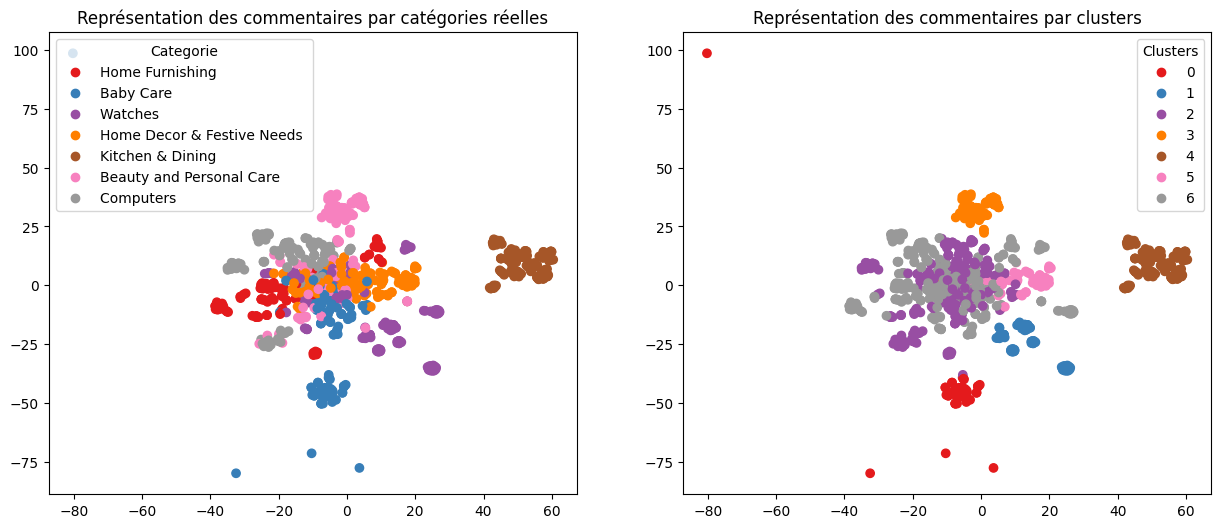

ARI :  0.2986


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [ ]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_umap_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(features)
    # Calcul de l'embedding Umap pour un BOW TF-IDF
    umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.3, metric='manhattan', random_state=42)
    X_umap = umap.fit_transform(features)

    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_umap, cls.labels_

In [ ]:
# visualisation du Tsne selon les vraies catégories et selon les clusters
def UMAP_visu_fct(X_umap, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_umap[:,0],X_umap[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des commentaires par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_umap[:,0],X_umap[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des commentaires par clusters')
    
    plt.show()
    print("ARI : ", ARI)

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


ARI :  0.2986 time :  12.0


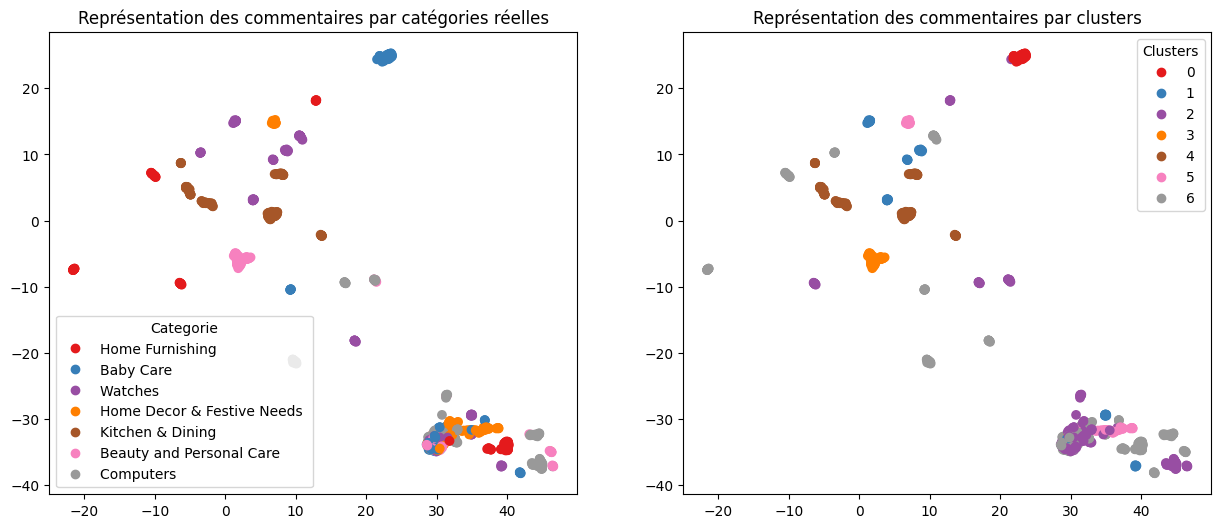

ARI :  0.2986


In [56]:
ARI, X_umap, labels = ARI_umap_fct(tfidf_preprocessed_embeddings['text4'])
UMAP_visu_fct(X_umap, y_cat_num, labels, ARI)

GENSIM

In [57]:
from gensim.models import Word2Vec

In [58]:
params = dict()

In [59]:
params[0] = dict(
    min_count=1,
    window=5,
    vector_size=100,
    workers=4,
    sg=0,
    hs=0,
    negative=5,
    ns_exponent=0.75,
    cbow_mean=1,
    alpha=0.05,
    min_alpha=0.0001,
    seed=42
)

In [60]:
params[1] = dict(
    min_count=1,
    window=7,
    vector_size=125,
    workers=4,
    sg=1,
    hs=0,
    negative=5,
    ns_exponent=0.75,
    cbow_mean=1,
    alpha=0.05,
    min_alpha=0.0001,
    seed=42
)

In [61]:
params[2] = dict(
    min_count=1,
    window=10,
    vector_size=150,
    workers=4,
    sg=1,
    hs=0,
    negative=5,
    ns_exponent=0.75,
    cbow_mean=1,
    alpha=0.05,
    min_alpha=0.0001,
    seed=42
)

In [62]:
params[3] = dict(
    min_count=3,
    window=10,
    vector_size=150,
    workers=4,
    sg=1,
    hs=0,
    negative=5,
    ns_exponent=0.75,
    cbow_mean=1,
    alpha=0.05,
    min_alpha=0.0001,
    seed=42
)

In [113]:
word_embeddings = dict()
model = dict()

for option in options:
    # Texte tokenisé
    text = [doc.split() for doc in flipkart_filtered[option]]

    for i in range(4):
        current_key = f'{option}'+f' {str(i)}'
        # Entraînement du modèle Word2Vec avec gensim
        model[option] = Word2Vec(sentences=text, **params[i])

        # Accès aux embeddings
        word_embeddings[current_key] = model[option].wv
        
        # Affichage du nombre de mots dans le vocabulaire
        print(f'{option} - Nombre de mots dans le vocabulaire: {len(word_embeddings[current_key].key_to_index)}')

product_name - Nombre de mots dans le vocabulaire: 2549
product_name - Nombre de mots dans le vocabulaire: 2549
product_name - Nombre de mots dans le vocabulaire: 2549
product_name - Nombre de mots dans le vocabulaire: 484
description - Nombre de mots dans le vocabulaire: 9587
description - Nombre de mots dans le vocabulaire: 9587
description - Nombre de mots dans le vocabulaire: 9587
description - Nombre de mots dans le vocabulaire: 3585
text - Nombre de mots dans le vocabulaire: 9587
text - Nombre de mots dans le vocabulaire: 9587
text - Nombre de mots dans le vocabulaire: 9587
text - Nombre de mots dans le vocabulaire: 4160


In [114]:
mean_embeddings = dict()
for key in word_embeddings.keys():
    # For each row in the flipkart_filtered text column, replace each word by its embedding and compute the mean of the embeddings
    mean_embeddings[key] = flipkart_filtered[key.split()[0]].apply(
        lambda x: np.mean(
            [
                word_embeddings[key][word]
                for word in x.split()
                if word in word_embeddings[key]
            ],
            axis=0,
        )
    ).dropna()

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [115]:
for key in mean_embeddings.keys():
    # Create a new DataFrame with the mean embeddings
    print(mean_embeddings[key].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0


In [116]:
mean_embeddings_df = dict()
for key in list(mean_embeddings.keys())[4:]:
    rng = mean_embeddings[key][0].shape
    mean_embeddings_df[key] = pd.DataFrame(mean_embeddings[key].tolist(), columns=[f'{key}_{i}' for i in range(rng[0])])

In [127]:
for key in mean_embeddings_df.keys():    
    ARI, _, _ = ARI_fct(mean_embeddings_df[key])

ARI :  0.2464 time :  7.0
ARI :  0.2464 time :  8.0
ARI :  0.2426 time :  9.0
ARI :  0.2499 time :  10.0
ARI :  0.2477 time :  9.0
ARI :  0.2922 time :  9.0
ARI :  0.2882 time :  9.0
ARI :  0.3003 time :  10.0


# GLOVE

In [128]:
# Loading the vectors from the glove text file
def load_glove_vectors(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
    return words, word_to_vec_map


In [129]:
# Load the glove vectors 100d
words, word_to_vec_map = load_glove_vectors("./Glove/glove.6B.100d.txt")

In [130]:
# Print the number of words and the number of word vectors
print(f"Number of words: {len(words)}")
print(f"Number of word vectors: {len(word_to_vec_map)}")

Number of words: 400000
Number of word vectors: 400000


In [134]:
mean_glove_embeddings = dict()
for option in options:
    # For each row in the flipkart_filtered text column, replace each word by its embedding and compute the mean of the embeddings
    mean_glove_embeddings[option] = flipkart_filtered[option].apply(
        lambda x: np.mean(
            [
                word_to_vec_map[word]
                for word in x.split()
                if word in word_to_vec_map
            ],
            axis=0,
        )
    )

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [139]:
glove = dict()
for option in options:
    glove[option] = pd.DataFrame(mean_glove_embeddings[option].dropna().tolist(), index=mean_glove_embeddings[option].dropna().index, columns=[f"glove_{i}" for i in range(100)])

In [156]:
for option in options:
    print(f"GLOVE {option}: ")
    print("--------")
    ARI, X_tsne, labels = ARI_fct(glove[option])
    print("Non null values sample: ", len(labels))
    print()

GLOVE product_name: 
--------
ARI :  0.4627 time :  4.0
Non null values sample:  575

GLOVE description: 
--------
ARI :  0.2516 time :  8.0
Non null values sample:  1050

GLOVE text: 
--------
ARI :  0.2485 time :  10.0
Non null values sample:  1050



ARI :  0.4627 time :  5.0


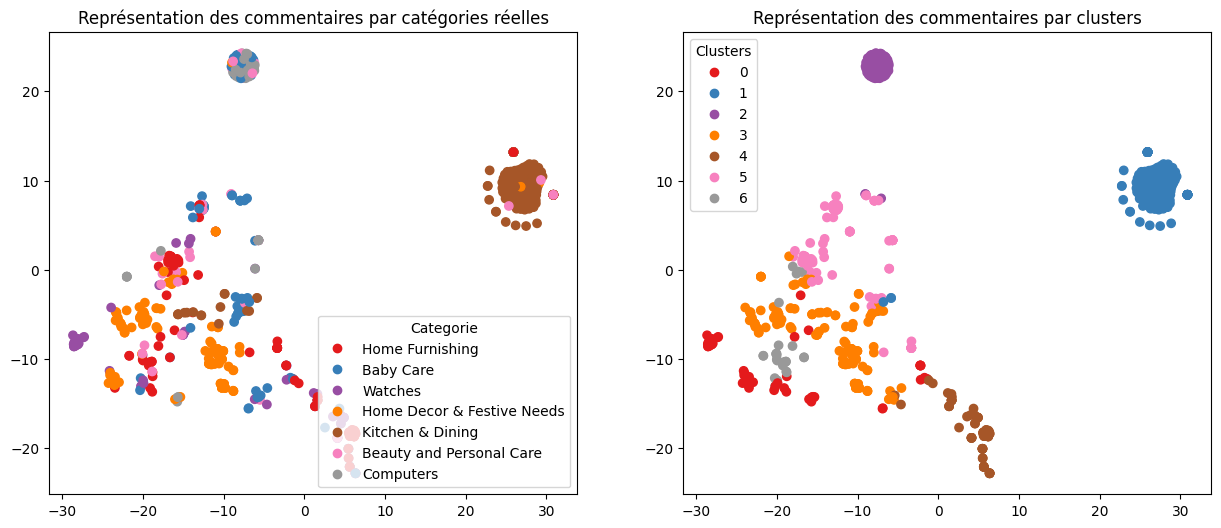

ARI :  0.4627


In [187]:
ARI, X_tsne, labels, y_cat_ser = ARI_fct(glove['product_name'])
TSNE_visu_fct(X_tsne, y_cat_ser.tolist(), labels, ARI)

Il existe une autre solution que de prendre la moyenne des embeddings.<br>
Nous allons utiliser une ponderation moyenne des word vectors d'un commentaire et ensuite effectué une PCA sur cet nouvel feature avant de l'envoyer au KMeans.<br>

In [174]:
# Make a weighted average of the word2vec embeddings
def weighted_average_word_vectors(words, word_to_vec_map):
    words = words.split()
    result = np.zeros(word_to_vec_map["hello"].shape)
    total_weight = 0
    for word in words:
        if word in word_to_vec_map:
            result += word_to_vec_map[word]
            total_weight += 1
    if total_weight == 0:
        return result
    return result / total_weight


In [194]:
weighted_embeddings = dict()
for option in options:
    weighted_embeddings[option] = flipkart_filtered[option].apply(
        lambda x: weighted_average_word_vectors(x, word_to_vec_map)
    )

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [195]:
# Create a DataFrame with the weighted embeddings
for option in options:
    print(f"WEIGHTED {option}: ")
    print("--------")
    ARI, X_tsne, labels = ARI_fct(pd.DataFrame(weighted_embeddings[option].tolist()))
    print("Non null values sample: ", len(labels))
    print()

WEIGHTED product_name: 
--------
ARI :  0.0212 time :  5.0


ValueError: too many values to unpack (expected 3)

# BERT

In [87]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers

os.environ["TF_KERAS"]='1'

In [88]:
# install torch
import torch

In [89]:
# Import BERT
from transformers import BertTokenizer, BertModel

In [90]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [91]:
# Tokenize the text column
tokenized = flipkart_filtered["text"].apply(lambda x: tokenizer(x, padding=True, truncation=True, return_tensors="pt"))

In [92]:
# Create a list of the tokenized tensors
tokenized_tensors = [tensor["input_ids"] for tensor in tokenized]

In [93]:
import tensorflow_hub as hub


In [94]:
# Load pretrained bert_en_uncased_L-12_H-768_A-12/3

model = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3")


In [95]:
# Load the bert_en_uncased_L-12_H-768_A-12/3 tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [96]:
text_exemple = "he loves working with data. It works like a charm at his work"

In [97]:
# Preprocess the text with AutoTokenizer
text_preprocessed = tokenizer(text_exemple, padding=True, truncation=True, return_tensors="tf")

In [98]:
type(text_preprocessed)

transformers.tokenization_utils_base.BatchEncoding

In [99]:
text_preprocessed.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [100]:
# Rename the keys with 'input_word_ids', 'input_mask' and 'input_type_ids'
text_preprocessed = {new_key: text_preprocessed[key] for key, new_key in zip(['input_ids', 'attention_mask', 'token_type_ids'], ['input_word_ids', 'input_mask', 'input_type_ids'])}

In [101]:
model(text_preprocessed)

{'pooled_output': <tf.Tensor: shape=(1, 768), dtype=float32, numpy=
 array([[-0.8115362 , -0.43281254, -0.8407893 ,  0.6736862 ,  0.25930652,
         -0.15918832,  0.80316085,  0.395319  , -0.60529697, -0.9999533 ,
         -0.1440674 ,  0.74857247,  0.9808339 ,  0.43200144,  0.89965   ,
         -0.5881434 , -0.1741608 , -0.6108952 ,  0.26124337, -0.05552725,
          0.7695719 ,  0.9998587 ,  0.23705362,  0.3294831 ,  0.4991836 ,
          0.8945839 , -0.6643711 ,  0.9050723 ,  0.9432497 ,  0.75134546,
         -0.62738633,  0.29033208, -0.98952585, -0.22210148, -0.85258085,
         -0.98485917,  0.47806135, -0.5897473 , -0.16911384, -0.05109132,
         -0.84457606,  0.42141047,  0.99988556, -0.80680716,  0.45777485,
         -0.32805568, -0.99999774,  0.29927924, -0.834642  ,  0.59672356,
          0.6314274 ,  0.35424152,  0.21421577,  0.40874404,  0.4602158 ,
          0.14649184, -0.13518348,  0.07417732, -0.2371627 , -0.56410396,
         -0.61290586,  0.43653405, -0.528765

In [102]:
# Tokenize the text column
bert_tokens = flipkart_filtered["text"].apply(lambda x: tokenizer(x, padding=True, truncation=True, return_tensors="tf"))

In [103]:
bert_tokens[5].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [104]:
# Create a list of the tokenized tensors
bert_tensors = bert_tokens.tolist()

# Map the keys in each tensor to 'input_word_ids', 'input_mask' and 'input_type_ids'
bert_tensors = [{new_key: tensor[key] for key, new_key in zip(['input_ids', 'attention_mask', 'token_type_ids'], ['input_word_ids', 'input_mask', 'input_type_ids'])} for tensor in bert_tensors]

In [105]:
bert_vectors = []

# for each tensor in the bert_tensors list, compute the embeddings with the BERT model
for tensor in bert_tensors:
    embeddings = model(tensor)
    bert_vectors.append(embeddings["pooled_output"].numpy().ravel())

In [106]:
# Unpack the list into a DataFrame
bert_df = pd.DataFrame(bert_vectors, index=flipkart_filtered.index, columns=[f"bert_{i}" for i in range(768)])

In [107]:
print("BERT: ")
print("--------")
ARI, X_tsne, labels = ARI_fct(bert_df)

BERT: 
--------


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.0665 time :  18.0


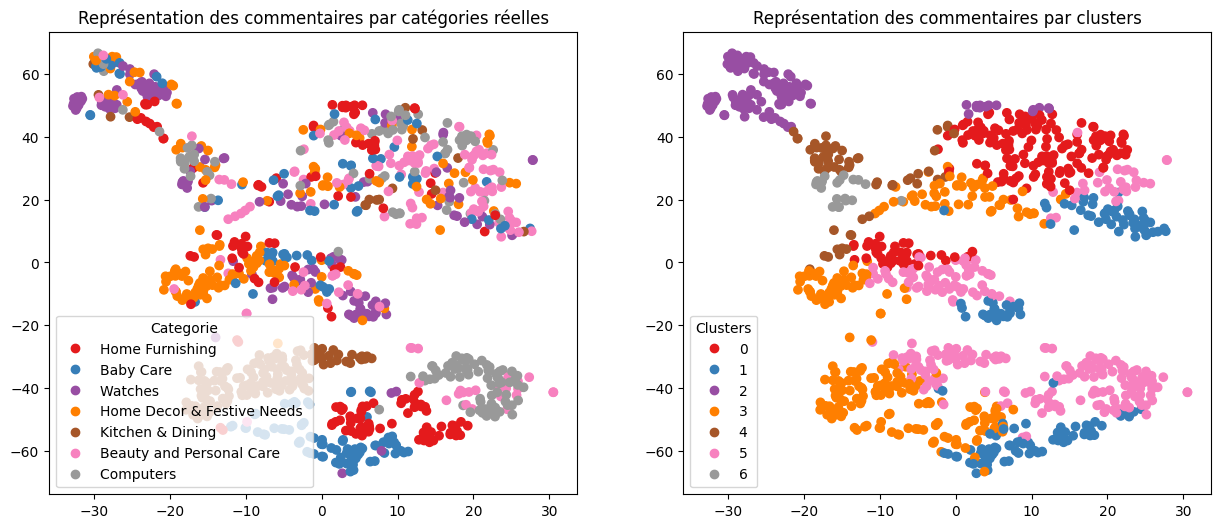

ARI :  0.0665


In [108]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [109]:
from transformers import RobertaTokenizer, TFRobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = TFRobertaModel.from_pretrained('roberta-base')
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='tf')
output = model(encoded_input)

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [110]:
# Tokenize the text column
roberta_tokens = flipkart_filtered["text"].apply(lambda x: tokenizer(x, padding=True, truncation=True, return_tensors="tf"))

In [111]:
roberta_output = roberta_tokens.apply(lambda x: model(x))

In [112]:
roberta_output[0].keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [113]:
# for each tensor in the bert_tensors list, compute the embeddings with the BERT model
roberta_vectors = []
for output in roberta_output:
    roberta_vectors.append(output["pooler_output"].numpy().ravel())

In [114]:
# Unpack the list into a DataFrame
roberta_df = pd.DataFrame(roberta_vectors, index=flipkart_filtered.index, columns=[f"bert_{i}" for i in range(768)])

In [115]:
print("ROBERTA: ")
print("--------")
ARI, X_tsne, labels = ARI_fct(roberta_df)

ROBERTA: 
--------


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.1345 time :  80.0


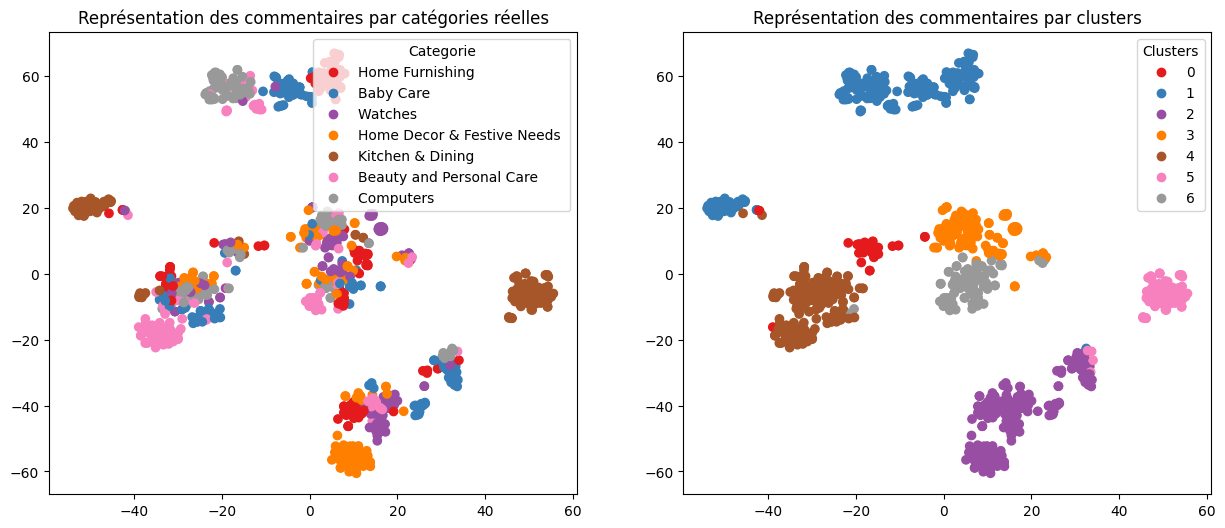

ARI :  0.1345


In [116]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE

Overview
The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length English text and the output is a 512 dimensional vector. 

In [117]:
import tensorflow_hub as hub

In [118]:
# Load the Universal Sentence Encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [119]:
# Encode the text column with the Universal Sentence Encoder
use_embeddings = flipkart_filtered["text"].apply(lambda x: embed([x]).numpy().ravel())

In [120]:
# Unpack the list into a DataFrame
use_df = pd.DataFrame(use_embeddings.tolist(), index=flipkart_filtered.index, columns=[f"use_{i}" for i in range(512)])

In [121]:
print("USE: ")
print("--------")
ARI, X_tsne, labels = ARI_fct(use_df)

USE: 
--------


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.3503 time :  71.0


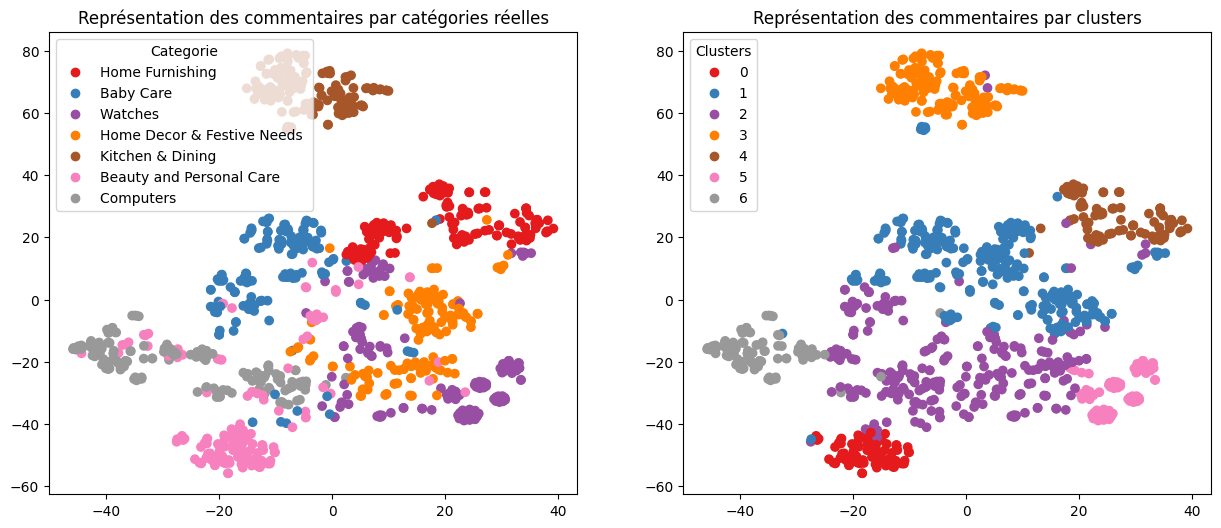

ARI :  0.3503


In [122]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# VISUAL BAG OF WORDS

**Notes** : <br>
BOVW : Bag of Visual Words<br>
The idea of BOVW is to represent an image as a set of unique features. Each feature, as in a classic BOW, consist of keypoints and descriptors.<br>
The keypoints are the points in the image that are invariant to scaling, rotation, and translation.<br>
The descriptors are the vectors that describe the keypoints.<br>


In [157]:
# import opencv
import cv2

In [158]:
# Define a feature extractor function
def feature_extractor(image_path):
    # Load the image
    image = cv2.imread(image_path)
    # Resize the image
    image_resized = cv2.resize(image, (224, 224))
    # Convert the image to RGB (OpenCV uses BGR by default)
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    # Normalize the image
    image_normalized = image_rgb / 255.0
    # Add a batch dimension
    image_batch = np.expand_dims(image_normalized, axis=0)
    return image_batch


In [203]:
# Create a SIFT object to detect keypoints and extract descriptors
extractor = cv2.SIFT_create()

In [204]:
path = "./Images/"
images = os.listdir(path)

In [205]:
# Pick the first image in the image directory
image_path = path + images[0]

Charger une image en niveaux de gris (grayscale) est souvent une étape importante dans le traitement d'images pour plusieurs raisons :

1. **Réduction de la Complexité** : Les images en couleur ont trois canaux (rouge, vert, bleu), ce qui augmente la complexité du traitement. En convertissant l'image en niveaux de gris, vous réduisez cette complexité à un seul canal, ce qui simplifie les calculs et accélère le traitement.

2. **Invariance aux Couleurs** : Pour de nombreuses tâches de vision par ordinateur, les informations de couleur ne sont pas nécessaires. Par exemple, pour la détection de contours, de formes ou de caractéristiques, les niveaux de gris suffisent souvent. Cela permet de se concentrer sur les variations d'intensité lumineuse plutôt que sur les variations de couleur.

3. **Consommation de Mémoire** : Les images en niveaux de gris consomment moins de mémoire que les images en couleur, ce qui peut être crucial pour des applications nécessitant le traitement de grandes quantités d'images ou des images de grande taille.

4. **Compatibilité avec les Algorithmes** : Certains algorithmes de traitement d'images et de vision par ordinateur, comme SIFT (Scale-Invariant Feature Transform), sont conçus pour fonctionner sur des images en niveaux de gris. Utiliser des images en couleur pourrait nécessiter une conversion interne en niveaux de gris, ce qui pourrait introduire des inefficacités.

Voici un exemple de code pour charger une image en niveaux de gris et détecter des points d'intérêt avec SIFT :





En résumé, charger une image en niveaux de gris est une pratique courante pour simplifier et optimiser le traitement d'images, en particulier pour des tâches où les informations de couleur ne sont pas essentielles.

La première méthode que je vais utiliser pour segmenter les images est la méthode de KMeans appliqué sur un Visual Bag of Words.<br>
Pour construire le Visual Bag of Words, je vais suivre les étapes suivantes :
- Extraire les features (keypoints + descriptors) des images avec SIFT.
- Regrouper les descriptors dans un nombre fini de clusters et identifier les centroids, qui formeront le corpus de nos mos visuels.
- Pour chaque image, utiliser le modèle KMeans pour attribuer un cluster à chaque descriptor SIFT.
- Le Visual Bow of Words contiendra dans les colonnes les centroids des clusters et dans les lignes la fréquence d'apparition de chaque centroid dans l'image.
- Enfin,nous ingérons le VBOW dans notre fonction de calcul de l'ARI en utilisant le KMeans à nouveau et obtenir la segmentation visuelle en 2D avec le TSNE.

La colonne `image`dans le dataframe `flipkart_filtered`contient l'ordre d'apparition des images.<br>
Nous allons spécifiquement recréer la liste des chemins de fichier en utilisant cet ordre :

In [258]:
# Définition du chemin d'accès au répertoire contenant les images
path = "./Images/"

# Création de la liste contenant les chemins d'accès ordonnées
image_paths = [path + image for image in flipkart_filtered['image']]

Je vais désormer créer une liste qui contiendra toutes les images encodées en niveaux de gris :

In [264]:
# Charge les images en niveaux de gris dans une liste
image_list = [cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in tqdm(image_paths)]

100%|██████████| 1050/1050 [00:10<00:00, 97.51it/s]


A ce niveau, les images ne sont pas forcément toutes de la même taille.<br>
Je vais donc redimensionner toutes les images sous le format 256x256 pixels :

In [ ]:
def resize_with_crop(greeimage, target_size):
    # Récupère les dimensions de l'image
    h, w = image.shape
    # Calcule la différence entre la hauteur et la largeur
    diff = h - w
    # Si la hauteur est plus grande que la largeur
    if diff > 0:
        # Crop l'image en hauteur
        image = image[diff // 2: -diff // 2]
    # Sinon si la largeur est plus grande que la hauteur
    elif diff < 0:
        # Crop l'image en largeur
        image = image[:, -diff // 2: diff // 2]
    # Resize l'image
    return cv2.resize(image, target_size)

In [269]:
# Redimensionne les imags sous un format 256x256 pixels
resized_images = [resize_with_crop(image, 256) for image in tqdm(image_list)]

100%|██████████| 1050/1050 [00:00<00:00, 3710.71it/s]


Nous pouvons maintenant passer à l'étape d'extraction des features SIFT pour chaque image.<br>
Nous allons créer une liste contenant tous les descripteurs SIFT pour chaque image que nous pourrons réutiliser par la suite :

In [276]:
def extract_sift_features(image):
    # Create a SIFT object to detect keypoints and extract descriptors
    extractor = cv2.SIFT_create()
    # Detect keypoints and extract descriptors
    keypoints, descriptors = extractor.detectAndCompute(image, None)
    return descriptors

In [275]:
# Crée une liste avec les descriptors SIFT sur les images de taille 256x256
sift_descriptors = [extract_sift_features(image) for image in tqdm(resized_images)]


100%|██████████| 1050/1050 [00:14<00:00, 70.00it/s]


In [277]:
# Crée une liste avec les descriptors SIFT sur les images de taille originale
sift_descriptors_original = [extract_sift_features(image) for image in tqdm(image_list)]

 64%|██████▍   | 677/1050 [04:20<02:32,  2.44it/s]

In [224]:
import cv2
import numpy as np

sift = cv2.SIFT_create()
descriptor_list = []  # Liste pour stocker les descripteurs de toutes les images

# Exemple pour plusieurs images
for image_path in image_paths:  # image_paths est une liste des chemins vers tes images
    file_path = path + image_path
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(image, None)

    if descriptors is not None:
        descriptor_list.append(descriptors)

# Empiler tous les descripteurs dans une seule grande matrice
all_descriptors = np.vstack(descriptor_list)


In [227]:
from sklearn.cluster import KMeans

In [229]:
# Import Kmeans mini batch
from sklearn.cluster import MiniBatchKMeans

In [228]:
# Choisir le nombre de clusters (nombre de "mots visuels")
n_clusters = 500  

# Appliquer KMeans sur les descripteurs combinés
kmeans = KMeans(n_clusters=n_clusters, random_state=314)
kmeans.fit(all_descriptors)

# Les centres des clusters seront tes "mots visuels"
visual_words = kmeans.cluster_centers_

In [234]:
descriptors[0].reshape(1, -1).shape

(1, 128)

In [237]:
histograms = []

for descriptors in tqdm(descriptor_list):  # descriptor_list contient les descripteurs de chaque imag
    histogram = np.zeros(n_clusters)
    for descriptor in tqdm(descriptors):
        idx = kmeans.predict(descriptor.reshape(1, -1))
        histogram[idx] += 1

    histogram = histogram / np.sum(histogram)  # Normalisation optionnelle
    histograms.append(histogram)


100%|██████████| 1049/1049 [18:00<00:00,  1.03s/it]


In [239]:
type(histograms)

list

In [240]:
# Convert the histograms list into a DataFrame
histograms_df = pd.DataFrame(histograms, columns=[f"hist_{i}" for i in range(n_clusters)])

In [242]:
# Use the ARIs function to compute the ARI between the true categories and the clusters
ARI, X_tsne, labels, y_cat_ser = ARI_fct(histograms_df)

ARI :  0.0021 time :  11.0


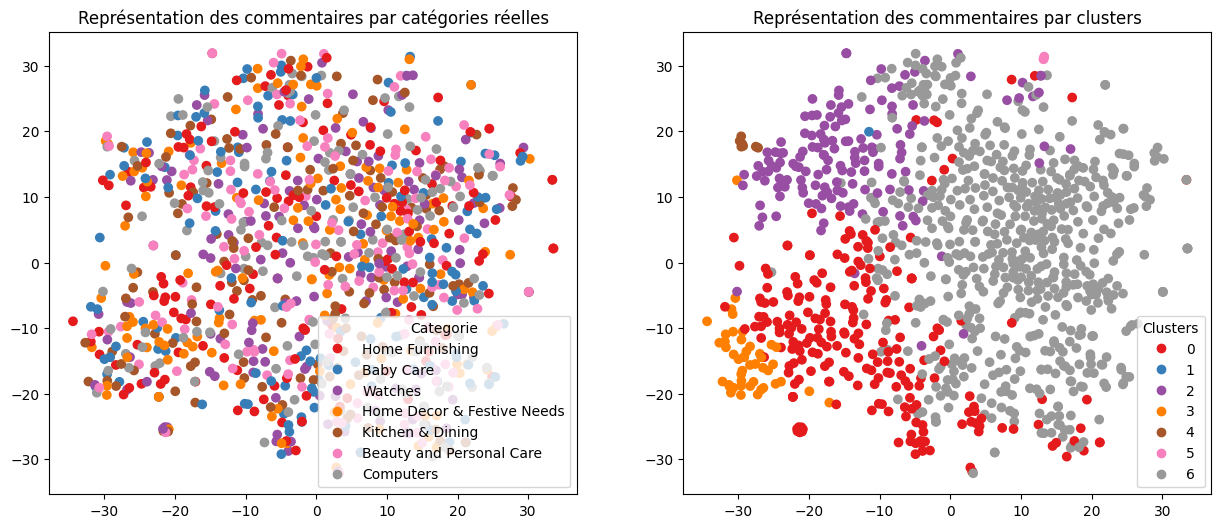

ARI :  0.0021


In [243]:
# Use the TSNE_visu_fct function to visualize the TSNE
TSNE_visu_fct(X_tsne, y_cat_ser.tolist(), labels, ARI)

In [244]:
histograms_df

,hist_0,hist_1,hist_2,hist_3,hist_4,hist_5,hist_6,hist_7,hist_8,hist_9,...,hist_490,hist_491,hist_492,hist_493,hist_494,hist_495,hist_496,hist_497,hist_498,hist_499
0,0.000715,0.015376,0.000000,0.000536,0.000179,0.001967,0.000358,0.001609,0.000179,0.003218,...,0.001430,0.000536,0.000536,0.000000,0.000715,0.000894,0.001252,0.000358,0.001430,0.000894
1,0.001410,0.001410,0.004231,0.000000,0.000000,0.001410,0.001410,0.000000,0.000000,0.000000,...,0.000000,0.005642,0.002821,0.000000,0.000000,0.001410,0.000000,0.001410,0.000000,0.000000
2,0.002462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000615,0.000000,0.006769,0.000000,0.000000,0.000000,0.000000
3,0.002096,0.004612,0.001258,0.000000,0.001258,0.000000,0.000419,0.000000,0.000000,0.002096,...,0.000839,0.006709,0.000839,0.002096,0.000000,0.003354,0.002096,0.000419,0.000839,0.000839
4,0.007887,0.000415,0.000000,0.000000,0.000830,0.000415,0.000000,0.000830,0.000000,0.002491,...,0.000830,0.000000,0.013284,0.000000,0.000000,0.000000,0.000000,0.003736,0.000830,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,0.001564,0.000000,0.003128,0.001564,0.000000,0.004692,0.002086,0.000521,0.000000,0.001564,...,0.002086,0.002607,0.000521,0.002086,0.001564,0.002086,0.001564,0.002607,0.005214,0.003650
1045,0.000859,0.004294,0.001431,0.000000,0.002290,0.004008,0.002863,0.000000,0.000000,0.002004,...,0.004581,0.000859,0.000573,0.001431,0.001145,0.002004,0.001718,0.002577,0.002863,0.002577
1046,0.000000,0.000000,0.003448,0.000000,0.006897,0.000000,0.000000,0.000000,0.000000,0.003448,...,0.000000,0.001724,0.000000,0.001724,0.000000,0.001724,0.000000,0.003448,0.001724,0.003448
1047,0.004306,0.002936,0.000587,0.003719,0.001174,0.000196,0.000783,0.003719,0.000196,0.003523,...,0.002740,0.001370,0.000587,0.003327,0.001957,0.002545,0.001762,0.002153,0.002740,0.001370


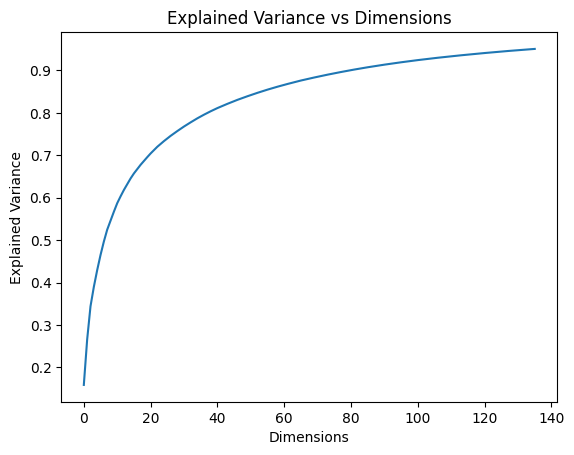

In [246]:
# Make a pca on histograms df and visualize the elbow method
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)
pca.fit(histograms_df)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.title("Explained Variance vs Dimensions")
plt.show()

In [248]:
# Transform the histograms_df with the pca
histograms_pca = pca.transform(histograms_df)

# Transform histograms pca into a dataframe
histograms_pca = pd.DataFrame(histograms_pca, columns=[f"hist_pca_{i}" for i in range(histograms_pca.shape[1])])

# Use the ARIs function to compute the ARI between the true categories and the clusters
ARI, X_tsne, labels, y_cat_ser = ARI_fct(histograms_pca)

ARI :  0.0007 time :  10.0


L'objet [`keypoints`](command:_github.copilot.openSymbolFromReferences?%5B%22keypoints%22%2C%5B%7B%22uri%22%3A%7B%22%24mid%22%3A1%2C%22fsPath%22%3A%22c%3A%5C%5CUsers%5C%5CBS6517%5C%5CDocuments_local%5C%5Cprojet_6%5C%5Coc_projet_6%5C%5C1_notebook_classification_072024.ipynb%22%2C%22_sep%22%3A1%2C%22external%22%3A%22vscode-notebook-cell%3A%2Fc%253A%2FUsers%2FBS6517%2FDocuments_local%2Fprojet_6%2Foc_projet_6%2F1_notebook_classification_072024.ipynb%23Y320sZmlsZQ%253D%253D%22%2C%22path%22%3A%22%2Fc%3A%2FUsers%2FBS6517%2FDocuments_local%2Fprojet_6%2Foc_projet_6%2F1_notebook_classification_072024.ipynb%22%2C%22scheme%22%3A%22vscode-notebook-cell%22%2C%22fragment%22%3A%22Y320sZmlsZQ%3D%3D%22%7D%2C%22pos%22%3A%7B%22line%22%3A0%2C%22character%22%3A0%7D%7D%5D%5D "Go to definition") en OpenCV est une liste d'objets `cv2.KeyPoint`. Chaque objet `KeyPoint` représente un point d'intérêt détecté dans l'image et contient plusieurs attributs qui décrivent ce point. Voici les principaux attributs de l'objet `KeyPoint` :

1. **pt** : Un tuple (x, y) représentant la position du keypoint dans l'image.
2. **size** : La taille du keypoint, c'est-à-dire le diamètre du voisinage utilisé pour la détection.
3. **angle** : L'orientation du keypoint en degrés (de 0 à 360). Cela représente l'angle de la direction dominante du gradient autour du keypoint.
4. **response** : Une valeur de réponse qui indique la force du keypoint. Plus la valeur est élevée, plus le keypoint est fort.
5. **octave** : L'octave (échelle) dans laquelle le keypoint a été détecté. Cela est utilisé pour les algorithmes multi-échelles comme SIFT.
6. **class_id** : Un identifiant de classe optionnel pour le keypoint. Cela peut être utilisé pour des applications spécifiques où les keypoints doivent être classifiés.



In [168]:
print(keypoints[0].pt)
print(keypoints[0].size)
print(keypoints[0].angle)
print(keypoints[0].response)
print(keypoints[0].octave)
print(keypoints[0].class_id)

(3.1131632328033447, 564.3240966796875)
2.396592140197754
179.27517700195312
0.06975063681602478
4129535
-1




Voici une explication détaillée de chaque ligne :

1. **cv2.waitKey(0)** :
   - Cette fonction attend une entrée de touche de l'utilisateur.
   - L'argument [`0`](command:_github.copilot.openSymbolFromReferences?%5B%220%22%2C%5B%7B%22uri%22%3A%7B%22%24mid%22%3A1%2C%22fsPath%22%3A%22c%3A%5C%5CUsers%5C%5CBS6517%5C%5CDocuments_local%5C%5Cprojet_6%5C%5Coc_projet_6%5C%5C1_notebook_classification_072024.ipynb%22%2C%22_sep%22%3A1%2C%22external%22%3A%22vscode-notebook-cell%3A%2Fc%253A%2FUsers%2FBS6517%2FDocuments_local%2Fprojet_6%2Foc_projet_6%2F1_notebook_classification_072024.ipynb%23Y324sZmlsZQ%253D%253D%22%2C%22path%22%3A%22%2Fc%3A%2FUsers%2FBS6517%2FDocuments_local%2Fprojet_6%2Foc_projet_6%2F1_notebook_classification_072024.ipynb%22%2C%22scheme%22%3A%22vscode-notebook-cell%22%2C%22fragment%22%3A%22Y324sZmlsZQ%3D%3D%22%7D%2C%22pos%22%3A%7B%22line%22%3A3%2C%22character%22%3A12%7D%7D%5D%5D "Go to definition") signifie que la fonction attend indéfiniment jusqu'à ce qu'une touche soit pressée.
   - Si un autre nombre est passé en argument, la fonction attendra ce nombre de millisecondes avant de continuer l'exécution du programme.
   - Cette fonction est souvent utilisée après [`cv2.imshow()`](command:_github.copilot.openSymbolFromReferences?%5B%22cv2.imshow()%22%2C%5B%7B%22uri%22%3A%7B%22%24mid%22%3A1%2C%22fsPath%22%3A%22c%3A%5C%5CUsers%5C%5CBS6517%5C%5CDocuments_local%5C%5Cprojet_6%5C%5Coc_projet_6%5C%5C1_notebook_classification_072024.ipynb%22%2C%22_sep%22%3A1%2C%22external%22%3A%22vscode-notebook-cell%3A%2Fc%253A%2FUsers%2FBS6517%2FDocuments_local%2Fprojet_6%2Foc_projet_6%2F1_notebook_classification_072024.ipynb%23Y324sZmlsZQ%253D%253D%22%2C%22path%22%3A%22%2Fc%3A%2FUsers%2FBS6517%2FDocuments_local%2Fprojet_6%2Foc_projet_6%2F1_notebook_classification_072024.ipynb%22%2C%22scheme%22%3A%22vscode-notebook-cell%22%2C%22fragment%22%3A%22Y324sZmlsZQ%3D%3D%22%7D%2C%22pos%22%3A%7B%22line%22%3A3%2C%22character%22%3A0%7D%7D%5D%5D "Go to definition") pour permettre à l'utilisateur de voir l'image affichée avant que la fenêtre ne se ferme.

2. **cv2.destroyAllWindows()** :
   - Cette fonction ferme toutes les fenêtres ouvertes par OpenCV.
   - Elle est utilisée pour s'assurer que toutes les fenêtres créées par [`cv2.imshow()`](command:_github.copilot.openSymbolFromReferences?%5B%22cv2.imshow()%22%2C%5B%7B%22uri%22%3A%7B%22%24mid%22%3A1%2C%22fsPath%22%3A%22c%3A%5C%5CUsers%5C%5CBS6517%5C%5CDocuments_local%5C%5Cprojet_6%5C%5Coc_projet_6%5C%5C1_notebook_classification_072024.ipynb%22%2C%22_sep%22%3A1%2C%22external%22%3A%22vscode-notebook-cell%3A%2Fc%253A%2FUsers%2FBS6517%2FDocuments_local%2Fprojet_6%2Foc_projet_6%2F1_notebook_classification_072024.ipynb%23Y324sZmlsZQ%253D%253D%22%2C%22path%22%3A%22%2Fc%3A%2FUsers%2FBS6517%2FDocuments_local%2Fprojet_6%2Foc_projet_6%2F1_notebook_classification_072024.ipynb%22%2C%22scheme%22%3A%22vscode-notebook-cell%22%2C%22fragment%22%3A%22Y324sZmlsZQ%3D%3D%22%7D%2C%22pos%22%3A%7B%22line%22%3A3%2C%22character%22%3A0%7D%7D%5D%5D "Go to definition") sont correctement fermées lorsque l'utilisateur a fini de les visualiser.


In [169]:
# Display the keypoints on the image
image_with_kp = cv2.drawKeypoints(image, keypoints, None)
cv2.imshow("Image with keypoints", image_with_kp)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [171]:
# Make clusters from the descriptors with KMeans
kmeans = cluster.KMeans(n_clusters=500)
kmeans.fit(descriptors)


KMeans(n_clusters=500)

In [202]:
descriptors.shape

(401, 128)

In [198]:
pd.Series(kmeans.labels_).value_counts()

478    58
493    51
1      49
22     49
3      48
       ..
464     2
494     1
194     1
447     1
421     1
Name: count, Length: 500, dtype: int64

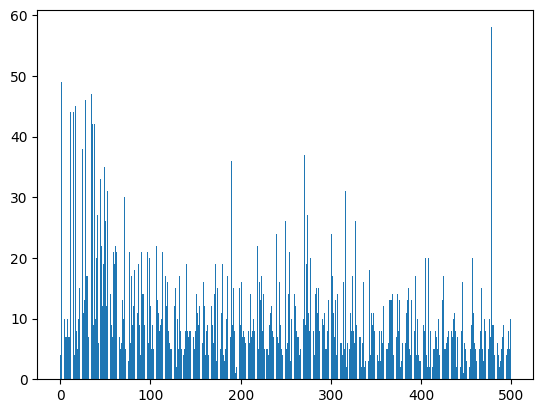

In [172]:
# Make visual histograms of the clusters
hist, _ = np.histogram(kmeans.labels_, bins=500)
plt.bar(range(500), hist)
plt.show()

In [201]:
kmeans.cluster_centers_

array([[ 2.        ,  4.5       , 12.        , ..., 13.75      ,
        36.25      , 49.5       ],
       [ 5.57143   ,  8.306122  , 16.34694   , ..., 36.612247  ,
        18.387756  , 11.918367  ],
       [57.7647    ,  6.2352953 ,  0.05882263, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [16.75      , 57.250004  , 11.625     , ..., 41.375     ,
         6.75      , 14.75      ],
       [22.4       , 14.6       , 16.4       , ..., 11.200001  ,
        21.800001  , 15.8       ],
       [17.099998  ,  2.8000011 , 22.7       , ...,  1.7999992 ,
        32.2       , 44.300003  ]], dtype=float32)

In [196]:
# Construit le visual bag of word


ValueError: Buffer dtype mismatch, expected 'const double' but got 'float'